## 6A. Building the Network

[**Return to the main chapter contents**](6.%20More%20Realistic%20Model%20and%20Advanced%20Features.ipynb)

In this section we will build a reduced model of the Mouse Primary Visual Cortical Area (V1) mainly focusing on cells in Layer 4 (L4) which receive most of the visual input from the thalamus. The rules used to build even the reduced V1 model is quite complex and are not necessary to understand in order to run the advanced simulations done in other sections of the chapter. But if one wants a better undertanding of how to build a more advanced model like our L4 or V1 model, hopefully this will help.

Note that rebuilding the model can take significant time and computing power. We have already saved a pre-built version of L4 network model in the **network/** directory. Thus we recommend saving a backup of the **network/** directory before rebuilding the model.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime
from datetime import timedelta

from bmtk.builder import NetworkBuilder

--------------------------------------------------------------------------

  Local host:   atl1-1-01-013-7-2
  Local device: mlx5_0
--------------------------------------------------------------------------


### The Layer 4 column

#### Adding nodes

As before we will start by defining what types of cell models to use in our circuit. The properties are saved in the **l4_models** so we can easily update and rebuild the circuit, adding/changing the models and altering the ratio as needed.

The full L4 model can take hours to build and simulate, so for this case we will use the **l4_fraction** variable so that our circuit will have only 5% of the actual number of cells. 

In [5]:
with open("abc_stats.json") as ifptr:
    l4model_stats = json.load(ifptr)
l4model_stats["locations"]["VISp4"]["neurons"]

{'Sst': {'ei': 'i',
  'fraction': 0.31512605042016806,
  'N': 2218,
  'dims': {},
  'model_name': '',
  'model_type': '',
  'model_template': '',
  'dynamics_params': ''},
 'Lamp5': {'ei': 'i',
  'fraction': 0.018487394957983194,
  'N': 130,
  'dims': {},
  'model_name': '',
  'model_type': '',
  'model_template': '',
  'dynamics_params': ''},
 'Sst-Chodl': {'ei': 'i',
  'fraction': 0.0,
  'N': 0,
  'dims': {},
  'model_name': '',
  'model_type': '',
  'model_template': '',
  'dynamics_params': ''},
 'Pvalb': {'ei': 'i',
  'fraction': 0.5327731092436975,
  'N': 3750,
  'dims': {},
  'model_name': '',
  'model_type': '',
  'model_template': '',
  'dynamics_params': ''},
 'Vip': {'ei': 'i',
  'fraction': 0.1319327731092437,
  'N': 928,
  'dims': {},
  'model_name': '',
  'model_type': '',
  'model_template': '',
  'dynamics_params': ''},
 'GABA-Other': {'ei': 'i',
  'fraction': 0.0016806722689075631,
  'N': 11,
  'dims': {},
  'model_name': '',
  'model_type': '',
  'model_template': '',

In [6]:
l4_fraction = 0.05

l4_models = {
  "VisL4": {
    "depth_range": [310.0, 430.0],
    "models": [
      {
        "N": l4model_stats["locations"]["VISp4"]["neurons"]["Sst"]["N"],
        "model_name": "Sst_501282204",
        "cell_line": "i4Sst",
        "ei": "i",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "501282204_glif_lif_asc_config.json"
      },
      {
        "N": l4model_stats["locations"]["VISp4"]["neurons"]["Pvalb"]["N"],
        "model_name": "Pvalb_478958894",
        "cell_line": "i4Pvalb",
        "ei": "i",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "478958894_glif_lif_asc_config.json"
      },
      {
        "N": l4model_stats["locations"]["VISp4"]["neurons"]["Pvalb"]["N"],
        "model_name": "Htr3a_474626527",
        "cell_line": "i4Htr3a",
        "ei": "i",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "474626527_glif_lif_asc_config.json"
      },
      {
        "N": l4model_stats["locations"]["VISp4"]["neurons"]["IT"]["N"],
        "model_name": "Scnn1a_517982558",
        "cell_line": "e4Scnn1a",
        "ei": "e",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "517982558_glif_lif_asc_config.json"
      },
    ]
  }
}

In the above we specified the cortical depth of the cells (*depth_range*) and the number of cells of each type (*N*), but we don't explicity have the coordinates for all our cells. So before we can start building the network we create a function **generate_column_positions** that will, for given values of *N* and *depth_range*, randomly and evenly place cells in a column. 

In [7]:
outer_radius = 845.0*np.sqrt(l4_fraction)
radial_range = (1.0, outer_radius)

def generate_column_positions(n_cells, depth_range, radial_range):
    radius_outer = radial_range[1]
    radius_inner = radial_range[0]

    phi = 2.0 * np.pi * np.random.random(n_cells)
    r = np.sqrt((radius_outer**2 - radius_inner**2)*np.random.random(n_cells) + radius_inner**2)
    x = r * np.cos(phi)
    z = r * np.sin(phi)
    y = (depth_range[1] - depth_range[0])*np.random.random(n_cells) + depth_range[0]
    return x, y, z

Now we can create the l4 network and start adding the cells. We will call the ```NetworkBuilder.add_nodes()``` method once for each cell type using a simple for loop to iterate over the **l4_models**.

In [8]:
np.random.seed(12345)
l4 = NetworkBuilder('l4')

for layer, layer_dict in l4_models.items():
    depth_range = layer_dict['depth_range']
    for model_props in layer_dict['models']:
        n_cells = int(model_props['N']*l4_fraction)
        x, y, z = generate_column_positions(n_cells, depth_range=depth_range, radial_range=radial_range)
        l4.add_nodes(
            N=n_cells,
            layer=layer,
            x=x,
            y=y,
            z=z,
            tuning_angle=np.linspace(0.0, 360.0, n_cells),
            model_name=model_props['model_name'],
            cell_line=model_props['cell_line'],
            ei=model_props['ei'],
            model_type=model_props['model_type'],
            model_template=model_props['model_template'],
            dynamics_params=model_props['dynamics_params']
        )


#### Adding Edges

Now we want to add recurrent edges. We will want to add a unique "edge-type" model for every source and target cell type. We will use some existing properties found in the literature, as well as some properties that have already be optimized by trial-and-error, which we have saved in the file **l4_l4_edge_properties.csv**.

In [9]:
import pandas as pd

edge_props_lu = pd.read_csv('l4_l4_edge_properties.csv', sep=' ').set_index(['target_model_name', 'source_type'])

The **compute_pair_type_parameters** function will be used to calculate specific properties of the edges based on the pre- and post-synaptic cell types.

In [10]:
def compute_pair_type_parameters(source_type, target_type, target_model_name):
    cc_props = edge_props_lu.loc[target_model_name, source_type]

    # A_literature is different for every source-target pair and was estimated from the literature.
    A_literature = cc_props["A_literature"]

    # R0 read from the dictionary, but setting it now at 75 um for all cases but this allows us to change it
    R0 = cc_props["R0"]

    # Sigma is taken from the literature or was measured internally at the Allen Institute
    sigma = cc_props["sigma"]

    # Gaussian equation was integrated and solved to calculate A_new. See accompanying documentation.
    A_new = A_literature / ((sigma / R0) ** 2 * (1 - np.exp(-((R0 / sigma) ** 2))))

    # Due to the measured values in the literature being from multiple sources and approximations that were
    # made by us and the literature (for instance R0 = 75um and sigma from the literature), we found that it is
    # possible for A_new to go slightly above 1.0 in which case we rescale it to 1.0. We confirmed that if this
    # does happen, it is for a few cases and is not much higher than 1.0.
    if A_new > 1.0:
        A_new = 1.0

    ##### To include orientation tuning ####
    # Many cells will show orientation tuning and the relative difference in orientation tuning angle will influence
    # probability of connections as has been extensively report in the literature. This is modeled here with a linear
    # where B in the largest value from 0 to 90 (if the profile decays, then B is the intercept, if the profile
    # increases, then B is the value at 90). The value of G is the gradient of the curve.
    # The calculations and explanation can be found in the accompanying documentation with this code.

    # Extract the values from the dictionary for B, the maximum value and G the gradient
    B_ratio = cc_props["B_ratio"]
    B_ratio = np.nan if B_ratio is None else B_ratio

    # Check if there is orientation dependence in this source-target pair type. If yes, then a parallel calculation
    # to the one done above for distance dependence is made though with the assumption of a linear profile.
    if not np.isnan(B_ratio):
        # The scaling for distance and orientation must remain less than 1 which is calculated here and reset
        # if it is greater than one. We also ensure that the area under the p(delta_phi) curve is always equal
        # to one (see documentation). Hence the desired ratio by the user may not be possible, in which case
        # an warning message appears indicating the new ratio used. In the worst case scenario the line will become
        # horizontal (no orientation tuning) but will never "reverse" slopes.

        # B1 is the intercept which occurs at (0, B1)
        # B2 is the value when delta_phi equals 90 degree and hence the point (90, B2)
        B1 = 2.0 / (1.0 + B_ratio)
        B2 = B_ratio * B1

        AB = A_new * max(B1, B2)
        if AB > 1.0:
            if B1 >= B2:
                B1_new = 1.0 / A_new
                delta = B1 - B1_new
                B1 = B1_new
                B2 = B2 + delta
            elif B2 > B1:
                B2_new = 1.0 / A_new
                delta = B2 - B2_new
                B2 = B2_new
                B1 = B1 + delta

            B_ratio = B2 / B1

        G = (B2 - B1) / 90.0

    # If there is no orientation dependence, record this by setting the intercept to NaN
    else:
        B1 = np.NaN
        G = np.NaN

    return A_new, sigma, G, B1


The **connect_cells** function is the primary way to calculate the the number of synapses between any two individual cells. It uses the properties calculated above, plus the distance between any two cells, to calculate if two cells are connected.

We will pass in **connect_cells** into the ```NetworkBuilder.add_edges()``` method so that it will be called by ```build()```.

In [11]:
def connect_cells(sources, target, A_new, sigma, gradient, intercept, nsyn_range=[3, 8]):
    sources_x = np.array([s["x"] for s in sources])
    sources_z = np.array([s["z"] for s in sources])
    sources_tuning_angle = [s["tuning_angle"] for s in sources]

    # Calculate the intersomatic distance between the current two cells (in 2D - not including depth)
    intersomatic_distance = np.sqrt((sources_x-target["x"])**2 + (sources_z - target["z"])**2)

    if not np.isnan(gradient):  # Check if there is orientation dependence
        # Calculate the difference in orientation tuning between the cells
        delta_orientation = np.array(sources_tuning_angle, dtype=float) - float(target["tuning_angle"])

        # For OSI, convert to quadrant from 0 - 90 degrees
        delta_orientation = abs(abs(abs(180.0 - abs(delta_orientation)) - 90.0) - 90.0)

        # Calculate the probability two cells are connected based on distance and orientation
        p_connect = (A_new*np.exp(-((intersomatic_distance/sigma)**2))*(intercept + gradient * delta_orientation))

    else:  # If no orienatation dependence
        # Calculate the probability two cells are connected based on distance only
        p_connect = A_new * np.exp(-((intersomatic_distance / sigma) ** 2))

    # If not the same cell (no self-connections)
    if 0.0 in intersomatic_distance:
        p_connect[np.where(intersomatic_distance == 0.0)[0][0]] = 0

    # Decide which cells get a connection based on the p_connect value calculated
    p_connected = np.random.binomial(1, p_connect)
    p_connected[p_connected == 1] = np.random.randint(nsyn_range[0], nsyn_range[1], len(p_connected[p_connected == 1]))

    nsyns_ret = [Nsyn if Nsyn != 0 else None for Nsyn in p_connected]
    return nsyns_ret


Now we are ready to use the ```add_edges()``` method to add connections for every source/target type. Then, we will call ```build``` and ```save``` to save the l4 network + recurrent connections into the **network/** directory.

In [12]:
models = l4_models['VisL4']['models']
for src_model, trg_model in product(models, repeat=2):
    trg_model_name = trg_model['model_name']
    trg_type = trg_model['cell_line']
    trg_ei = trg_model['ei']
    src_type = src_model['cell_line']
    src_ei = src_model['ei']

    A_new, sigma, gradient, intercept = compute_pair_type_parameters(src_type, trg_type, trg_model_name)
    if A_new > 0.0:
        if src_ei == 'e' and trg_ei == 'e':
            weight_fnc = 'DirectionRule_EE'
            weight_sigma = 30.0
        elif src_ei == 'i' and trg_ei == 'i':
            weight_fnc = 'DirectionRule_others'
            weight_sigma = 50.0
        else:
            weight_fnc = 'DirectionRule_others'
            weight_sigma = 90

        edge_props = edge_props_lu.loc[trg_model_name, src_type]

        edge_params_file = '{}2{}.json'.format(src_ei, trg_ei)

        l4.add_edges(
            source={'cell_line': src_type},
            target={'cell_line': trg_type},
            iterator='all_to_one',
            connection_rule=connect_cells,
            connection_params={'A_new': A_new, 'sigma': sigma, 'gradient': gradient, 'intercept': intercept},
            dynamics_params=edge_params_file,
            syn_weight=edge_props['weight_max'],
            delay=edge_props['delay'],
            weight_function=weight_fnc,
            weight_sigma=weight_sigma,
            model_template='static_synapse'
        )
        
l4.build()
l4.save(output_dir='network')

### The LGN

#### Nodes

Next we create the LGN cells which will be used to convert visual inputs into spike trains and synapse onto our L4 cells, providing the inputs to our model. The LGN cells are divided into different types of cells with temporal and spatial behaviors and mapped onto a 240x120 receptive field.

In [13]:
x_grids, y_grids = 15, 10
field_size = (240.0, 120.0)
lgn_fraction = 1.0

lgn_models = {
  "sON_TF1": {
    "N": 1050,
    # "model_name": "sON_TF1",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF1",
    "dynamics_params": "sON_TF1.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sON_TF2": {
    "N": 750,
    # "model_name": "sON_TF2",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF2",
    "dynamics_params": "sON_TF2.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sON_TF4": {
    "N": 1050,
    # "model_name": "sON_TF4",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF4",
    "dynamics_params": "sON_TF4.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sON_TF8": {
    "N": 2250,
    # "model_name": "sON_TF8",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF8",
    "dynamics_params": "sON_TF8.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF1": {
    "N": 1200,
    # "model_name": "sOFF_TF1",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF1",
    "dynamics_params": "sOFF_TF1.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF2": {
    "N": 1200,
    # "model_name": "sOFF_TF2",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF2",
    "dynamics_params": "sOFF_TF2.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF4": {
    "N": 2250,
    # "model_name": "sOFF_TF4",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF4",
    "dynamics_params": "sOFF_TF4.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF8": {
    "N": 1200,
    # "model_name": "sOFF_TF8",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF8",
    "dynamics_params": "sOFF_TF8.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF15": {
    "N": 1050,
    "subtype": "sOFF",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF15",
    "dynamics_params": "sOFF_TF15.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "tOFF_TF4": {
    "N": 1500,
    "subtype": "tOFF",
    "model_type": "virtual",
    "model_template": "lgnmodel:tOFF_TF4",
    "dynamics_params": "tOFF_TF4.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "tOFF_TF8": {
    "N": 750,
    "subtype": "tOFF",
    "model_type": "virtual",
    "model_template": "lgnmodel:tOFF_TF8",
    "dynamics_params": "tOFF_TF8.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "tOFF_TF15": {
    "N": 1200,
    "subtype": "tOFF",
    "model_type": "virtual",
    "model_template": "lgnmodel:tOFF_TF15",
    "dynamics_params": "tOFF_TF15.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sONsOFF_001": {
    "N": 1200,
    "subtype": "sONsOFF",
    "model_type": "virtual",
    "model_template": "lgnmodel:sONsOFF_001",
    "dynamics_params": "sOFF_TF4.json",
    "non_dom_params": "sON_TF4.json",
    "size_range": [6, 6],
    "sf_sep": 6.0,
    "tuning_angle": True
  },
  "sONtOFF_001": {
    "N": 750,
    "subtype": "sONtOFF",
    "model_type": "virtual",
    "model_template": "lgnmodel:sONtOFF_001",
    "dynamics_params": "tOFF_TF8.json",
    "non_dom_params": "sON_TF4.json",
    "size_range": [9, 9],
    "sf_sep": 4.0,
    "tuning_angle": True
  }
}

The **positions_grid** function is used to randomly place cells on the 240x120 plain, separated into ```x_grids * y_grids``` individual grids, so that each section of the receptive field has roughly the same number of each cell type. 

In [14]:
def positions_grids(n_cells, x_grids=15, y_grids=10, size=(240.0, 120.0)):
    """Randomly generate x, y positions on a screen/rectangle of given "size" divided into evenly sized
    grids. The number of cells in each grid will be evenly distributed += 1 cell. But within each grid 
    the distribution of coordinates are randomized.
    """
    
    n_grids = x_grids*y_grids
    tile_width = size[0]/x_grids
    tile_height = size[1]/y_grids

    # Keeps track of the total number of cells in each grid evenly divided, if n_cells is not divisible
    #  by n_grids then randomly distribute the remaining cells into different grids
    grid_cell_counts = np.full(y_grids*x_grids, int(n_cells/n_grids))
    grid_remainder = n_cells % n_grids
    if grid_remainder != 0:
        rand_idxs = np.random.choice(range(len(grid_cell_counts)), size=grid_remainder, replace=False)
        grid_cell_counts[rand_idxs] += 1
    grid_cell_counts = grid_cell_counts.reshape((x_grids, y_grids))
    
    # for each grid generate random coordinates
    xs = np.zeros(n_cells)
    ys = np.zeros(n_cells)
    x_indx, y_indx = 0, 0
    for i in range(x_grids):
        for j in range(y_grids):
            n = grid_cell_counts[i, j]           
            xs[x_indx:(x_indx+n)] = np.random.uniform(i*tile_width, (i+1)*tile_width, n)
            ys[y_indx:(y_indx+n)] = np.random.uniform(j*tile_height, (j+1)*tile_height, n)
            x_indx += n
            y_indx += n
    
    return xs, ys

In [15]:
lgn = NetworkBuilder('lgn')
for model_name, params in lgn_models.items():
    n_cells = int(params['N']*lgn_fraction)
    x, y = positions_grids(n_cells, x_grids=x_grids, y_grids=y_grids, size=field_size)
    size_range = params['size_range']
    lgn.add_nodes(
        N=params['N'],
        model_name=model_name,
        location='LGN',
        subtype=params['subtype'],
        model_type=params['model_type'],
        model_template=params['model_template'],
        dynamics_params=params['dynamics_params'],
        non_dom_params=params.get('non_dom_params', None),
        x=x,
        y=y,
        tuning_angle=[np.NaN]*n_cells if params['tuning_angle'] else np.linspace(0.0, 360.0, n_cells),
        spatial_size=np.random.uniform(size_range[0], size_range[1], n_cells),
        sf_sep=params.get('sf_sep', None)
    )

Let's plot the LGN cells to make sure our cells are randomly but evenly distributed across the receptive field.

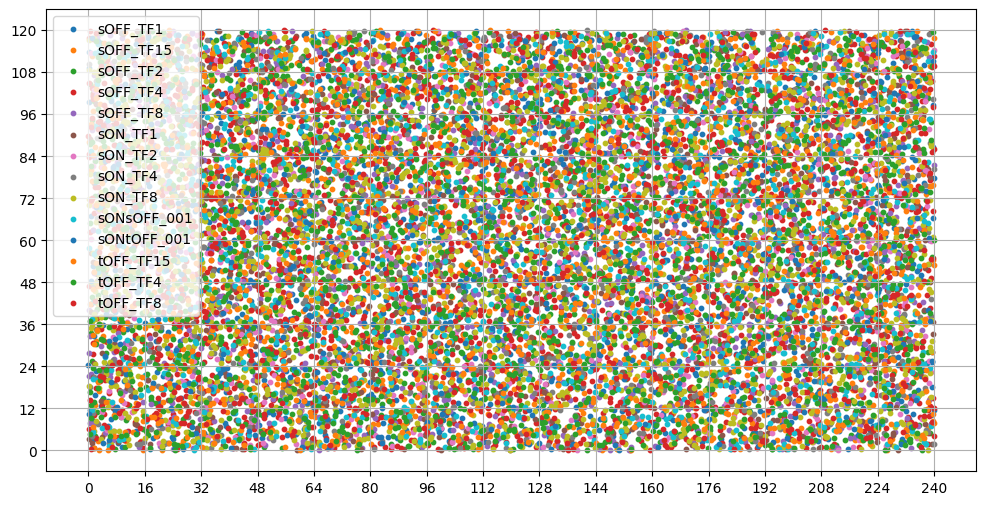

In [16]:
def plot_grids(lgn_net, x_grids=15, y_grids=10, size=(240.0, 120.0)):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    lgn_df = pd.DataFrame({
        'model_name': [n['model_name'] for n in lgn_net.nodes()],
        'x': [n['x'] for n in lgn_net.nodes()],
        'y': [n['y'] for n in lgn_net.nodes()],
    })
    for model_name, model_df in lgn_df.groupby('model_name'):
        ax.scatter(model_df['x'].values, model_df['y'].values, s=10, label=model_name)
    
    ax.set_xticks(np.arange(0, size[0]+x_grids, size[0]/x_grids))
    ax.set_yticks(np.arange(0, size[1]+y_grids, size[1]/y_grids))
    ax.legend()
    ax.grid()
    
plot_grids(lgn, x_grids=x_grids, y_grids=y_grids, size=field_size)

#### Edges

Now we will add connections from the LGN cells to the L4 cells. Like with recurrent networks our connectivity properties are based on existing literature as well as properties that have already been optimized using trial-and-error.

In [17]:
lgn_connections = {
  "e4Nr5a1": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.5272113965417778,
      "delay": 1.7,
      "dynamics_params": "lgn_exc.json",
      "model_template": "static_synapse"
    }
  },
  "e4Rorb": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.518666852825,
      "delay": 1.7,
      "dynamics_params": "lgn_exc.json",
      "model_template": "static_synapse"
    }
  },
  "e4Scnn1a": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.5173743580285,
      "delay": 1.7,
      "dynamics_params": "lgn_exc.json",
      "model_template": "static_synapse"
    }
  },
  "e4other": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.5152488843942,
      "delay": 1.7,
      "dynamics_params": "lgn_exc.json",
      "model_template": "static_synapse"
    }
  },
  "i4Htr3a": {
    "connection_params": {
      "probability": 0.444,
      "poissonParameter": 2.0,
      "sON_ratio": 0.75,
      "centers_d_min": 6.0,
      "centers_d_max": 10.0,
      "ON_OFF_w_min": 8.5,
      "ON_OFF_w_max": 11.0,
      "aspectRatio_min": 2.2,
      "aspectRatio_max": 2.4,
      "N_syn": 20
    },
    "edge_types_params": {
      "syn_weight": 0.0,
      "delay": 1.7,
      "dynamics_params": "lgn_inh.json",
      "model_template": "static_synapse"
    }
  },
  "i4Pvalb": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.75,
      "centers_d_min": 6.0,
      "centers_d_max": 10.0,
      "ON_OFF_w_min": 10.0,
      "ON_OFF_w_max": 13.0,
      "aspectRatio_min": 1.6,
      "aspectRatio_max": 1.8,
      "N_syn": 75
    },
    "edge_types_params": {
      "syn_weight": 1.7916764292750003,
      "delay": 1.7,
      "dynamics_params": "lgn_inh.json",
      "model_template": "static_synapse"
    }
  },
  "i4Sst": {
    "connection_params": {
      "probability": 0.333,
      "poissonParameter": 2.0,
      "sON_ratio": 0.75,
      "centers_d_min": 6.0,
      "centers_d_max": 10.0,
      "ON_OFF_w_min": 8.5,
      "ON_OFF_w_max": 11.0,
      "aspectRatio_min": 2.2,
      "aspectRatio_max": 2.4,
      "N_syn": 25
    },
    "edge_types_params": {
      "syn_weight": 0.0,
      "delay": 1.7,
      "dynamics_params": "lgn_inh.json",
      "model_template": "static_synapse"
    }
  }
}

The ```select_lgn_sources``` function will be used by the NetworkBuilder to choose the number of synaptic connections between each source (LGN) cell and target (L4) cell. It uses a combination of a priori parameters plus coordinates mapping to determine connectivty of LGN cells onto the L4.

In [18]:
def get_selection_probability(src_type, lgn_models_subtypes_dictionary):
    current_model_subtypes = lgn_models_subtypes_dictionary[src_type[0:4]]['sub_types']
    current_model_probabilities = lgn_models_subtypes_dictionary[src_type[0:4]]['probabilities']
    lgn_model_idx = [i for i, model in enumerate(current_model_subtypes) if src_type == model][0]
    return current_model_probabilities[lgn_model_idx]


def select_lgn_sources(sources, target, lgn_mean, probability, poissonParameter, sON_ratio, centers_d_min,
                       centers_d_max, ON_OFF_w_min, ON_OFF_w_max, aspectRatio_min, aspectRatio_max, N_syn):
    source_ids = [s.node_id for s in sources]

    # Check if target supposed to get a connection and if not, then no need to keep calculating.
    if np.random.random() > probability:
        return [None]*len(source_ids)

    subfields_centers_distance_L = centers_d_max - centers_d_min
    subfields_ON_OFF_width_L = ON_OFF_w_max - ON_OFF_w_min
    subfields_width_aspect_ratio_L = aspectRatio_max - aspectRatio_min

    x_position_lin_degrees = np.tan(0.07*np.array(target['x'])*np.pi/180.0)*180.0/np.pi
    y_position_lin_degrees = np.tan(0.04*np.array(target['z'])*np.pi/180.0)*180.0/np.pi

    vis_x = lgn_mean[0] + ((x_position_lin_degrees))  # - l4_mean[0]) / l4_dim[0]) * lgn_dim[0]
    vis_y = lgn_mean[1] + ((y_position_lin_degrees))  # - l4_mean[2]) / l4_dim[2]) * lgn_dim[1]

    ellipse_center_x0 = vis_x  # tar_cells[tar_gid]['vis_x']
    ellipse_center_y0 = vis_y  # tar_cells[tar_gid]['vis_y']

    tuning_angle = float(target['tuning_angle'])
    tuning_angle = None if np.isnan(tuning_angle) else tuning_angle
    #tuning_angle = None if math.isnan(target['tuning_angle']) else target['tuning_angle']
    if tuning_angle is None:
        ellipse_b0 = (ON_OFF_w_min + np.random.uniform(0.0, 1.0)*subfields_ON_OFF_width_L)/2.0  # Divide by 2 to convert from width to radius.
        ellipse_b0 = 2.5 * ellipse_b0  # 1.5 * ellipse_b0
        ellipse_a0 = ellipse_b0  # ellipse_b0
        top_N_src_cells_subfield = 15  # 20
        ellipses_centers_halfdistance = 0.0
        tuning_angle_value = 0.0
    else:
        tuning_angle_value = float(tuning_angle)
        ellipses_centers_halfdistance = (centers_d_min + np.random.uniform(0.0, 1.0)* subfields_centers_distance_L) / 2.0
        ellipse_b0 = (ON_OFF_w_min + np.random.uniform(0.0, 1.0) * subfields_ON_OFF_width_L) / 2.0  # Divide by 2 to convert from width to radius.
        ellipse_a0 = ellipse_b0 * (aspectRatio_min + np.random.uniform(0.0, 1.0) * subfields_width_aspect_ratio_L)
        ellipse_phi = tuning_angle_value + 180.0 + 90.0  # Angle, in degrees, describing the rotation of the canonical ellipse away from the x-axis.
        ellipse_cos_mphi = np.cos(-np.radians(ellipse_phi))
        ellipse_sin_mphi = np.sin(-np.radians(ellipse_phi))
        top_N_src_cells_subfield = 8  # 10 #9

        if np.random.random() < sON_ratio:
            cell_sustained_unit = 'sON_'
        else:
            cell_sustained_unit = 'sOFF_'

    cell_TF = np.random.poisson(poissonParameter)
    while cell_TF <= 0:
        cell_TF = np.random.poisson(poissonParameter)

    sON_subunits = np.array([1., 2., 4., 8.])
    sON_sum = np.sum(abs(cell_TF - sON_subunits))
    p_sON = (1 - abs(cell_TF - sON_subunits) / sON_sum) / (len(sON_subunits) - 1)

    sOFF_subunits = np.array([1., 2., 4., 8., 15.])
    sOFF_sum = np.sum(abs(cell_TF - sOFF_subunits))
    p_sOFF = (1 - abs(cell_TF - sOFF_subunits) / sOFF_sum) / (len(sOFF_subunits) - 1)

    tOFF_subunits = np.array([4., 8., 15.])
    tOFF_sum = np.sum(abs(cell_TF - tOFF_subunits))
    p_tOFF = (1 - abs(cell_TF - tOFF_subunits) / tOFF_sum) / (len(tOFF_subunits) - 1)

    # to match previous algorithm reorganize source cells by type
    cell_type_dict = {}
    for lgn_model in lgn_models:
        cell_type_dict[lgn_model] = [(src.node_id, src) for src in sources if src['model_name'] == lgn_model]


    lgn_models_subtypes_dictionary = {
        'sON_': {'sub_types': ['sON_TF1', 'sON_TF2', 'sON_TF4', 'sON_TF8'], 'probabilities': p_sON},
        'sOFF': {'sub_types': ['sOFF_TF1', 'sOFF_TF2', 'sOFF_TF4', 'sOFF_TF8', 'sOFF_TF15'], 
                 'probabilities': p_sOFF
                },
        'tOFF': {'sub_types': ['tOFF_TF4', 'tOFF_TF8', 'tOFF_TF15'], 'probabilities': p_tOFF},
    }

    src_cells_selected = {}
    for src_type in cell_type_dict.keys():
        src_cells_selected[src_type] = []

        if tuning_angle is None:
            ellipse_center_x = ellipse_center_x0
            ellipse_center_y = ellipse_center_y0
            ellipse_a = ellipse_a0
            ellipse_b = ellipse_b0
        else:
            if ('tOFF_' in src_type[0:5]):
                ellipse_center_x = ellipse_center_x0 + ellipses_centers_halfdistance * ellipse_sin_mphi
                ellipse_center_y = ellipse_center_y0 + ellipses_centers_halfdistance * ellipse_cos_mphi
                ellipse_a = ellipse_a0
                ellipse_b = ellipse_b0
            elif ('sON_' in src_type[0:5] or 'sOFF_' in src_type[0:5]):
                ellipse_center_x = ellipse_center_x0 - ellipses_centers_halfdistance * ellipse_sin_mphi
                ellipse_center_y = ellipse_center_y0 - ellipses_centers_halfdistance * ellipse_cos_mphi
                ellipse_a = ellipse_a0
                ellipse_b = ellipse_b0
            else:
                # Make this a simple circle.
                ellipse_center_x = ellipse_center_x0
                ellipse_center_y = ellipse_center_y0
                # Make the region from which source cells are selected a bit smaller for the transient_ON_OFF 
                # cells, since each source cell in this case produces both ON and OFF responses.
                ellipse_b = ellipses_centers_halfdistance/2.0 #0.01 
                ellipse_a = ellipse_b0 #0.01 #ellipse_b0

        # Find those source cells of the appropriate type that have their visual space coordinates within the
        # ellipse.
        for src_id, src_dict in cell_type_dict[src_type]:
            x, y = (src_dict['x'], src_dict['y'])
            x = x - ellipse_center_x
            y = y - ellipse_center_y

            x_new = x
            y_new = y
            if tuning_angle is not None:
                x_new = x * ellipse_cos_mphi - y * ellipse_sin_mphi
                y_new = x * ellipse_sin_mphi + y * ellipse_cos_mphi

            if ((x_new / ellipse_a) ** 2 + (y_new / ellipse_b) ** 2) <= 1.0:
                if tuning_angle is not None:
                    if src_type == 'sONsOFF_001' or src_type == 'sONtOFF_001':
                        src_tuning_angle = float(src_dict['tuning_angle'])
                        delta_tuning = abs(abs(abs(180.0-abs(tuning_angle_value-src_tuning_angle)%360.0)-90.0)-90.0)
                        if delta_tuning < 15.0:
                            src_cells_selected[src_type].append(src_id)

                    # elif src_type in ['sONtOFF_001']:
                    #     src_cells_selected[src_type].append(src_id)

                    elif cell_sustained_unit in src_type[:5]:
                        selection_probability = get_selection_probability(src_type, lgn_models_subtypes_dictionary)
                        if np.random.random() < selection_probability:
                            src_cells_selected[src_type].append(src_id)

                    elif 'tOFF_' in src_type[:5]:
                        selection_probability = get_selection_probability(src_type, lgn_models_subtypes_dictionary)
                        if np.random.random() < selection_probability:
                            src_cells_selected[src_type].append(src_id)

                else:
                    if (src_type == 'sONsOFF_001' or src_type == 'sONtOFF_001'):
                        src_cells_selected[src_type].append(src_id)
                    else:
                        selection_probability = get_selection_probability(src_type, lgn_models_subtypes_dictionary)
                        if np.random.random() < selection_probability:
                            src_cells_selected[src_type].append(src_id)

    select_cell_ids = [id for _, selected in src_cells_selected.items() for id in selected]
    return [N_syn if id in select_cell_ids else None for id in source_ids]


In [19]:
for layer, layer_dict in l4_models.items():
    for model_props in layer_dict['models']:
        model_name = model_props['model_name']
        cell_line = model_props['cell_line']
        
        conn_props = lgn_connections[cell_line]['connection_params']
        conn_props['lgn_mean'] = (field_size[0]/2.0, field_size[1]/2.0)
        edge_props = lgn_connections[cell_line]['edge_types_params']
        lgn.add_edges(
            source=lgn.nodes(),
            target=l4.nodes(model_name=model_name),
            connection_rule=select_lgn_sources,
            connection_params=conn_props,
            iterator='all_to_one',
            **edge_props
        )

start_time = datetime.now()
lgn.build()
lgn.save(output_dir='network')
end_time = datetime.now()
print('build time:', timedelta(seconds=(end_time - start_time).total_seconds()))

build time: 0:05:46.748586


### Simulated Background Noise

Finally, we will want to simulate inputs the L4 receives from non-thalamic/non-cortical neurons. We call this background or "BKG", and will simply consist of a single cell that provides noisy synaptic input to all cells. 

In [20]:
bkg = NetworkBuilder('bkg')
bkg.add_nodes(
    N=1, 
    pop_name='SG_001', 
    ei='e', 
    location='BKG',
    model_type='virtual'
)
    
bkg_edges_df = pd.read_csv('bkg_edge_models.csv', sep=' ')
for _, row in bkg_edges_df.iterrows():
    trg_type = row['target_label']

    edge_params = {
        'source': bkg.nodes(),
        'target': l4.nodes(cell_line=trg_type),
        'connection_rule': lambda s, t, n: n,
        'connection_params': {'n': 100},
        'dynamics_params': row['dynamics_params'],
        'syn_weight': row['syn_weight'],
        'delay': row['delay'],
        'model_template': 'static_synapse'
    }
    bkg.add_edges(**edge_params)

bkg.build()
bkg.save(output_dir='network')

### Next Steps

In this tutorial we have built our L4 (Mouse Primary visual cortex Layer 4) network with recurrent connections and feedforward inputs from the LGN (thalamus lateral geniculate nucleus) and BKG (non-thalamacortical background) cells. If everything executed correctly we should see the appropriate SONATA circuit files in the **network/** directory.

For the next part of Chapter 6 we'll show how to run multiple simulations on the circuit in a variety of different conditions.

[**Return to the main chapter contents**](6.%20More%20Realistic%20Model%20and%20Advanced%20Features.ipynb)